the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 59960.890725 from DATE-END'. [astropy.wcs.wcs]


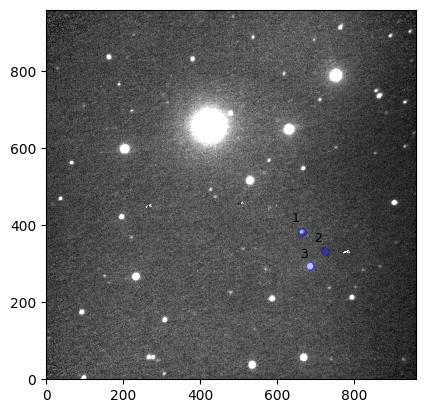

In [9]:
import os
import pandas as pd
from photometry import Photometry
from scripts.tools import sort_files
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from photometry import Photometry
from copy import copy

star_name = "GRB 1149293"
_set = "first"
camera = 3
src_path = os.path.join(
    "..",
    "Pol charact MOPTOP",
    "Scientific objects",
    star_name,
    f"{_set} set",
    star_name,
)


file = os.path.join(src_path, os.listdir(src_path)[0])
image = fits.getdata(file)
median = np.median(image)
std = np.median(np.abs(image - median))
plt.imshow(
    image, vmax=median + 7 * std, vmin=median - 3 * std, origin="lower", cmap="gray"
)

csv_file = os.path.join(src_path, "..", "setup", f"objects coordinates.csv")
df = pd.read_csv(csv_file)
objects = {
    "name": df["name"],
    "ra": df[f"ra_cam{camera}"],
    "dec": df[f"dec_cam{camera}"],
}
objects = pd.DataFrame.from_dict(objects)
phot = Photometry(file, objects)
phot.reset_object_coords()
for idx, _object in enumerate(phot.obj_list):
    name, x, y = _object.name, _object.xcoord, _object.ycoord
    color = "b"
    if name == "original":
        color = "r"
    plt.plot(x, y, f"{color}o", alpha=0.25)
    plt.annotate(f"{idx+1}", (x * 0.99, y * 1.05), ha="right", va="bottom", fontsize=9)

plt.show()

# Create photometry.csv

In [10]:
objects_photometry = {}
for obj_name in objects["name"]:
    objects_photometry[obj_name] = {
        "mjd": [],
        "xcoord": [],
        "ycoord": [],
        "psf_radius": [],
        "star_photons": [],
        "star_error": [],
    }


image_list = sort_files(src_path, f"{camera}_e")
for file in image_list:
    try:
        file_path = os.path.join(src_path, file)

        phot = Photometry(file_path, objects)
        phot.reset_object_coords()
        phot.calc_psf_radius()
        phot.calc_sky_photons()
        phot.calc_psf_photons()

        for _object in phot.obj_list:
            objects_photometry[_object.name]["mjd"].append(_object.mjd)
            objects_photometry[_object.name]["xcoord"].append(_object.xcoord)
            objects_photometry[_object.name]["ycoord"].append(_object.ycoord)
            objects_photometry[_object.name]["psf_radius"].append(_object.psf_radius)
            objects_photometry[_object.name]["star_photons"].append(
                _object.star_photons
            )
            objects_photometry[_object.name]["star_error"].append(_object.star_err)
    except ValueError:
        continue


for obj_name, obj_info in objects_photometry.items():
    df = pd.DataFrame.from_dict(obj_info)
    csv_file = os.path.join(src_path, "..", "photometry", f"{obj_name}_cam{camera}.csv")
    df.sort_values(by=["mjd"])
    df.to_csv(csv_file, index=False)

Set MJD-END to 59960.881407 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881466 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881523 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881581 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881639 from DATE-END'. [astropy.wcs.wcs]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Set MJD-END to 59960.881697 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881755 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881813 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881871 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59960.881928 from DATE-END'. [

# Plot light curve

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


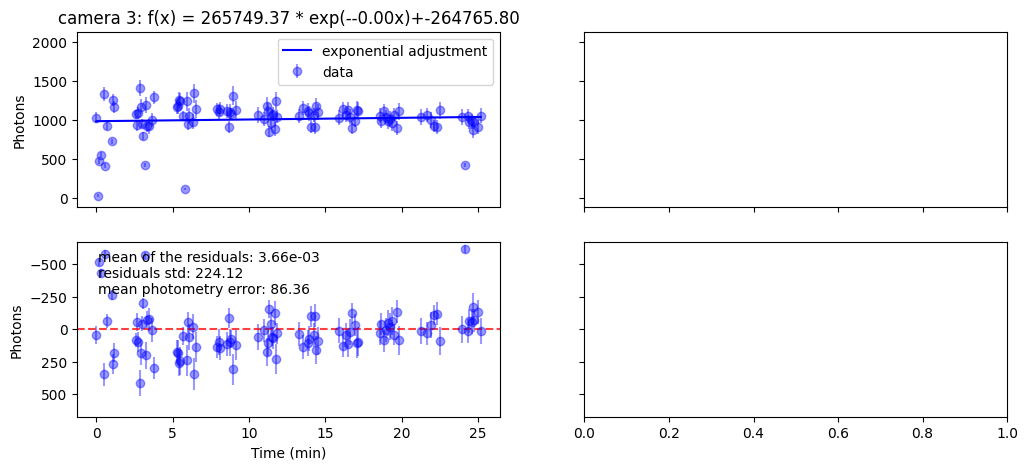

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import scipy
from math import sqrt, log10
from astropy.time import Time


def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c


def read_csv_files(comparison_magnitude):
    cand, comp_1 = [], []
    for _set in ["first"]:
        csv_path = os.path.join(src_path, "..", "photometry")
        csv_file = os.path.join(csv_path, f"comparison_cam{camera}.csv")
        comp_1.append(pd.read_csv(csv_file))
        csv_file = os.path.join(csv_path, f"candidate_cam{camera}.csv")
        cand.append(pd.read_csv(csv_file))
    n = 300
    df = pd.concat(cand, axis=0, ignore_index=True)
    cand = df["star_photons"][:n]
    cand_err = df["star_error"][:n]
    df = pd.concat(comp_1, axis=0, ignore_index=True)
    comp = df["star_photons"][:n]
    comp_err = df["star_error"][:n]

    star_mag, star_mag_err = calc_obj_magnitude(
        cand, cand_err, comp, comp_err, comparison_magnitude
    )

    mjd = df["mjd"][:n]
    mjd = (mjd - mjd[0]) * 24 * 60

    return mjd, cand / comp, cand_err


def calc_obj_magnitude(star_photons, star_err, comp_photons, comp_err, mag_comparison):
    star_photons, comp_photons = np.asarray(star_photons), np.asarray(comp_photons)

    tmp = star_photons / comp_photons
    tmp_err = np.abs(tmp) * np.sqrt(
        (star_err / star_photons) ** 2 + (comp_err / comp_photons) ** 2
    )
    star_mag = -2.5 * np.log10(tmp) + mag_comparison
    star_mag_err = 2.5 * tmp_err / (tmp * np.log2(10))
    return star_mag, star_mag_err


def calc_exponential_adjust(x, y):
    params, _ = scipy.optimize.curve_fit(monoExp, x, y)
    a, b, c = params
    exp_adjust = monoExp(x, a, b, c)
    return exp_adjust, a, b, c


def calc_linear_adjust(x, y):
    a, b = np.polyfit(x, y, 1)
    return a * x + b, a, b


def plot_light_curve(ax, mjd, cand, cand_err, exp_adjust, adjus_param, n_std=1):
    a, b, c = adjus_param
    mean = np.mean(cand)
    std = np.std(cand)
    ax.errorbar(
        mjd, cand, cand_err, marker="o", color="b", alpha=0.4, label="data", ls="none"
    )

    ax.plot(mjd, exp_adjust, "b-", label="exponential adjustment")
    ax.set_title(f"camera {camera}: f(x) = {a:.2f} * exp(-{b:.2f}x)+{c:.2f}")
    ax.legend()
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    ax.set_ylabel("Photons")
    # ax.invert_yaxis()


def plot_residuals(ax, cand, cand_err, exp_adjust, n_std=3):
    residuals = cand - exp_adjust
    mean = np.mean(residuals)
    std = np.std(residuals)

    ax.errorbar(
        mjd,
        residuals,
        cand_err,
        marker="o",
        color="b",
        alpha=0.4,
        label="data",
        ls="none",
    )
    ax.set_ylabel("Residuals")
    ax.axhline(mean, color="r", linestyle="--", alpha=0.75)
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Photons")
    ax.invert_yaxis()
    ax.annotate(
        f"mean of the residuals: {mean:.2e}\nresiduals std: {std:.2f}\nmean photometry error: {np.mean(cand_err):.2f}",
        (0.05, 0.95),
        fontsize=10,
        ha="left",
        va="top",
        xycoords="axes fraction",
    )


def plot_circular_data(mjd_start: float, ax):
    circulars = ["34487", "34483"]
    for idx, circular in enumerate(circulars):
        csv_path = os.path.join(src_path, "..", "Circulars", circular + ".csv")
        df = pd.read_csv(csv_path)
        utc = df["UT start"].values
        n = 4

        mjd = [Time(value, format="isot").to_value("mjd") for value in utc] - mjd_start
        mag = df["Rmag"]
        err = df["err"]

        ax.errorbar(
            mjd[:n],
            mag[:n],
            err[:n],
            marker="o",
            color=["r", "g"][idx],
            label="Circular " + circular,
            alpha=0.5,
            ls="none",
        )


comparison_magnitude = 14.406

fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex="col", sharey="row")
for camera in [3]:
    mjd, star, star_err = read_csv_files(comparison_magnitude)

    exp_adjust, *adjus_param = calc_exponential_adjust(mjd, star)

    ax = axs[0, camera - 3]
    plot_light_curve(ax, mjd, star, star_err, exp_adjust, adjus_param, 5)

    ax = axs[1, camera - 3]
    plot_residuals(ax, star, star_err, exp_adjust, 3)


plt.savefig(os.path.join(src_path, "..", "light_curve.png"))
plt.show()

# Plot object coordinates over the image

Text(0, 0.5, 'Residuals')

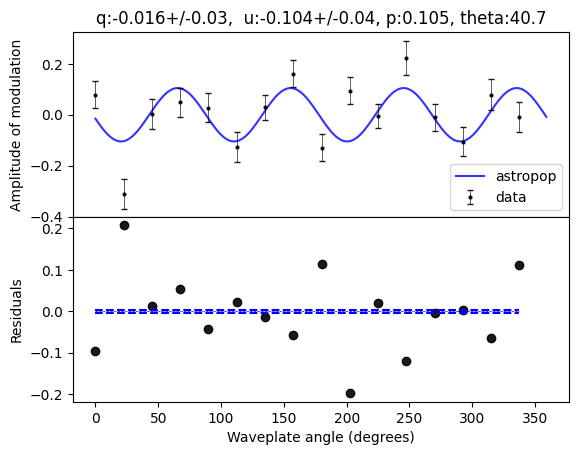

In [127]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import scipy
from math import sqrt, log10, pi, atan
from astropy.time import Time
from astropop.polarimetry.dualbeam import SLSDualBeamPolarimetry, halfwave_model
from astropy import units


def read_csv_files(camera):
    cand = []
    csv_path = os.path.join(src_path, "..", "photometry")
    csv_file = os.path.join(csv_path, f"original_cam{camera}.csv")
    n = 16
    idx = 0
    df = pd.read_csv(csv_file)
    cand = df["star_photons"][:n]
    cand_err = df["star_error"][:n]

    mjd = df["mjd"][:n]
    mjd = (mjd - mjd[0]) * 24 * 60

    return mjd, cand, cand_err


def plot_light_curve(ax, mjd, cand, cand_err, n_std=1):
    mean = np.mean(cand)
    std = np.std(cand)
    ax.errorbar(
        mjd, cand, cand_err, marker="o", color="b", alpha=0.4, label="data", ls="none"
    )
    ax.legend()
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    ax.set_ylabel("Photons")


def plot_residuals(ax, cand, cand_err, exp_adjust, n_std=3):
    residuals = cand - exp_adjust
    mean = np.mean(residuals)
    std = np.std(residuals)

    ax.errorbar(
        mjd,
        residuals,
        cand_err,
        marker="o",
        color="b",
        alpha=0.4,
        label="data",
        ls="none",
    )
    ax.set_ylabel("Residuals")
    ax.axhline(mean, color="r", linestyle="--", alpha=0.75)
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Photons")
    ax.invert_yaxis()
    ax.annotate(
        f"mean of the residuals: {mean:.2e}\nresiduals std: {std:.2f}\nmean photometry error: {np.mean(cand_err):.2f}",
        (0.05, 0.95),
        fontsize=10,
        ha="left",
        va="top",
        xycoords="axes fraction",
    )


mjd, ord, ord_err = read_csv_files(3)
mjd, extra, extra_err = read_csv_files(4)
angles = np.linspace(0, 22.5 * 15, 16)
pol_frac = (ord - extra) / (ord + extra)

pol = SLSDualBeamPolarimetry("halfwave", compute_k=True, zero=0)
line = np.arange(0, 360, 1) * units.degree

resul = pol.compute(angles, ord, extra, ord_err, extra_err)
model = halfwave_model(line, resul.q.nominal, resul.u.nominal, resul.zero)
noise = halfwave_model(angles, resul.q.nominal, resul.u.nominal, zero=None)
sigma = noise - resul.zi.nominal

q, u = float(resul.q), float(resul.u)
q_err, u_err = resul.q.uncertainty, resul.u.uncertainty
p = sqrt(q**2 + u**2)
theta = np.rad2deg(atan(u / q)) / 2

fig = plt.figure()
fig.subplots_adjust(hspace=0)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)

ax1.set_title(
    f"q:{q:.3f}+/-{q_err:.2f},  u:{u:.3f}+/-{u_err:.2f}, p:{p:.3f}, theta:{theta:.1f}"
)
ax1.plot(line, model, "-b", alpha=0.8, label="astropop")
ax1.errorbar(
    angles,
    resul.zi.nominal,
    yerr=resul.zi.std_dev,
    fmt="ko",
    ms=2,
    capsize=2,
    lw=0.5,
    alpha=0.9,
    label="data",
)
ax1.set_ylabel("Amplitude of modulation")
ax1.legend()

ax2.plot(angles, sigma, "ko", alpha=0.9, label="noise")
ax2.hlines(0, angles[0], angles[-1], linestyles="--", color="b", lw=0.5)
ax2.hlines(-np.mean(sigma), angles[0], angles[-1], linestyles="--", color="b")
ax2.hlines(np.mean(sigma), angles[0], angles[-1], linestyles="--", color="b")
ax2.set_xlabel("Waveplate angle (degrees)")
ax2.set_ylabel("Residuals")